# UFV - UNIVERSIDADE FEDERAL DE VIÇOSA
<h2>Núcleo Interdisciplinar de Análise de Sinais</h2>
<h2>Equipe NIAS-IA</h2>
<h3>Cláudio Amorim</h3>



<h2>Objetivos:</h2>

* Participar do desafio **Titanic - Machine Learning from Disaster**.
* Prever quais passageiros sobreviveram ao naufrágio do Titanic em 1912.
* Avaliar o impacto de técnicas de normalização de dados no desempenho de diferentes algoritmos de machine learning aplicados ao problema de classificação de sobreviventes do Titanic.
* Otimizar os modelos preditivos através do ajuste de hiperparâmetros utilizando a função gp_minimize, visando maximizar a acurácia das previsões.
* Implementar uma abordagem comparativa entre os modelos testados, analisando seus resultados tanto na validação cruzada quanto na submissão à plataforma Kaggle.


# Configuração do Ambiente

In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# data analysis
import numpy as np # linear algebra
np.random.seed(0)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from skopt import gp_minimize

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

print("Setup Completed!")

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
Setup Completed!


<h2>Load Datasets - Carregando os dados</h2>

**Dados de treino e teste**

<p><strong>Informações dos conjuntos de dados:</strong></p>
<a href="https://www.kaggle.com/competitions/titanic/data" target="_blank">Titanic - Machine Learning from Disaster</a>

In [111]:
#import train and test CSV files
train_work = pd.read_csv("../input/titanic/train.csv")
test_work = pd.read_csv("../input/titanic/test.csv")

#take a look at the training data
train_work.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<h2>Análise Exploratóra dos Dados</h2>

<h3>Conhecendo as Features - Mapeamento das Colunas</h3>

In [112]:
#mapear as colunas
#col = pd.Series(list(train_work.columns))
print(train_work.info())
print('='*60)
print(test_work.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

<h3>Categorização das Features</h3>


* **Features Numéricas:** Age (contínuas), Fare (contínuas), SibSp (Discreta), Parch (Discreta)
* **Features Categóricas:** Survived, Sex, Embarked, Pclass
* **Features Alfanuméricas:** Ticket, Cabin


<h3>Verificar valores nulos ou NAN</h3>

In [113]:
#verificar valores nulos ou NAN
print(train_work.isnull().sum())
print('='*60)
print(test_work.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [114]:
#descrição estátistica das features núméricas
est = train_work.describe()
est

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [115]:
#table = pd.pivot_table(train_work_dfv, index = ['Survived'], columns = ['Sex'], values = 'PassengerId', aggfunc = 'count')
#print(table)

# Analisar sobrevivência por Título
sex_survival = train_work.groupby('Sex')['Survived'].mean()
print(sex_survival)

print('='*60)

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [116]:
#Discrete Variable Correlation by Survival using group by aka pivot table
def correlation_survival(data, features):
    for x in features:
        if data[x].dtype != 'float64':
            print('Survival Correlation by:', x)
            print(data.groupby(x, as_index=False)['Survived'].mean())
            print('-'*60, '\n')

In [117]:
temp_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'] 

correlation_survival(train_work, temp_features)

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
------------------------------------------------------------ 

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
------------------------------------------------------------ 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
------------------------------------------------------------ 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
------------------------------------------------------------ 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
------------------------------------------------------------ 



<h2> Método para criação e tratamento das features</h2>

In [118]:
#%% Creating Features
def criar_features(X):
  subs = {'female':1, 'male':0}
  X['mulher'] = X['Sex'].map(subs) # Use .map() instead of .replace()
  X['Fare'] = X['Fare'].fillna(X['Fare'].mean())
  X['FareClass'] = np.where(X['Fare'] <= 7.91, 0,
                          np.where((X['Fare'] > 7.91) & (X['Fare'] <= 14.454), 1,
                                   np.where((X['Fare'] > 14.454) & (X['Fare'] <= 31), 2,
                                            np.where(X['Fare'] > 31, 3, 4))))
  X['Embarked'] = X['Embarked'].fillna('S')
  subs = {'S':1, 'C':2, 'Q':3}
  X['port'] = X['Embarked'].map(subs) # Use .map() instead of .replace()
  X['Age'] = X['Age'].fillna(X['Age'].mean())
  X['child'] = 1
  X['child'] = np.where(X['Age'] < 12, 1, 0)
  X['AgeClass'] = 0
  X['AgeClass'] = np.where(X['Age'] <= 16, 0,
                          np.where((X['Age'] > 16) & (X['Age'] <= 32), 1,
                                   np.where((X['Age'] > 32) & (X['Age'] <= 48), 2,
                                            np.where((X['Age'] > 48) & (X['Age'] <= 64), 3, 4))))
  X['AgeAndPClass'] = X['AgeClass'] * X['Pclass']
    
  # Extraindo features dado o tratamento dado aos passageiros
  X['Title'] = X['Name'].str.extract(r',\s*(\w+\.)')
  X['Title'] = X['Title'].replace('Mlle.', 'Miss.')
  X['Title'] = X['Title'].replace('Ms.', 'Miss.')
  X['Title'] = X['Title'].replace('Mme.', 'Mrs.')
  subs = {'Capt.':0.000000, 'Col.':0.500000, 'Don.':0.000000, 'Dr.':0.428571, 'Jonkheer.':0.000000, 'Lady.':1.000000, 
          'Major.':0.500000, 'Master.':0.575000, 'Miss.':0.697802, 'Mlle.':1.000000, 'Mme.':1.000000, 'Mr.':0.156673, 
          'Mrs.':0.792000, 'Ms.':1.000000, 'Rev.':0.000000, 'Sir.':1.000000}
  #subs = {'Mr.': 1, 'Miss.': 2, 'Mrs.': 3, 'Master.': 4, 'Rare.': 5}
  X['TitleSurvival'] = X['Title'].map(subs) # Use .map() instead of .replace()
  X['TitleSurvival'] = X['TitleSurvival'].fillna(X['TitleSurvival'].mean())
  
  # Coluna "SibSp" (Número de Irmãos e Cônjuges a Bordo)
  X['FamilySize'] = X['SibSp'] + X['Parch'] + 1  # Adicionar +1 para contar o próprio passageiro
  X['FamilySize'] = X['FamilySize'].fillna(X['FamilySize'].mean())
  X['IsAlone'] = 0
  X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
  
  # Coluna "Ticket"
  X['SharedTicket'] = X['Ticket'].duplicated(keep=False).astype(int)
  X['TicketPrefix'] = X['Ticket'].str.extract(r'([A-Za-z]+)')
  subs = {'A':0.068966, 'C':0.454545, 'CA':0.071429, 'F':0.666667, 'Fa':0.000000, 'LINE':0.250000, 'P':0.500000, 
          'PC':0.650000, 'PP':0.666667, 'S':0.142857, 'SC':0.538462, 'SCO':0.000000, 'SO':1.000000, 'SOTON':0.117647,
          'STON':0.444444, 'SW':1.000000, 'W':0.090909, 'WE':0.500000}
  X['TicketPrefixSurvival'] = X['TicketPrefix'].map(subs) # Use .map() instead of .replace()
  X['TicketPrefixSurvival'] = X['TicketPrefixSurvival'].fillna(X['TicketPrefixSurvival'].mean())
  
  # Coluna "Cabin"
  X['HasCabin'] = X['Cabin'].notnull().astype(int)
  X['CabinDeck'] = X['Cabin'].str[0]
  subs = {'A':0.466667, 'B':0.744681, 'C':0.593220, 'D':0.757576, 'E':0.750000, 'F':0.615385, 
          'G':0.500000, 'T':0.000000}
  X['CabinDeckSurvival'] = X['CabinDeck'].map(subs) # Use .map() instead of .replace()
  X['CabinDeckSurvival'] = X['CabinDeckSurvival'].fillna(X['CabinDeckSurvival'].mean())        
  return X

In [88]:
#%%Criação de Features com melhorias
def criar_features_melhorada(X):
    subs = {'female':1, 'male':0}
    X['Woman'] = X['Sex'].map(subs)

    X['Fare'] = X['Fare'].fillna(X['Fare'].mean())
    X['FareBin'] = pd.qcut(X['Fare'].astype(int), 4)
    
    # Tratamento de Embarked
    X['Embarked'] = X['Embarked'].fillna('S')
    subs = {'S':1, 'C':2, 'Q':3}
    X['Port'] = X['Embarked'].map(subs)
    
    # Tratamento de Age mais robusto
    age_mean = X['Age'].mean()
    age_std = X['Age'].std()
    X['Age'] = X['Age'].fillna(np.random.normal(age_mean, age_std))
    #X['Child'] = (X['Age'] < 12).astype(int)
    X['AgeBin'] = pd.cut(X['Age'].astype(int), 5)
    

    # Features de família aprimoradas
    X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
    
    X['IsAlone'] = 1
    X['IsAlone'].loc[X['FamilySize'] > 1] = 0
    #X['SmallFamily'] = ((X['FamilySize'] > 1) & (X['FamilySize'] <= 4)).astype(int)
    #X['LargeFamily'] = (X['FamilySize'] > 4).astype(int)

    # Extração de título mais completa
    #X['Title'] = X['Name'].str.extract(r',\s*([^\.]+)\.')
    #X['Title'] = X['Title'].replace(['Mlle', 'Ms'], 'Miss')
    #X['Title'] = X['Title'].replace('Mme', 'Mrs')
    #rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    #X['Title'] = X['Title'].replace(rare_titles, 'Rare')
    
    # Codificação de título baseada em sobrevivência real (calculada do train set)
    #title_survival = {
    #    'Master': 0.575, 'Miss': 0.698, 'Mr': 0.157, 
    #    'Mrs': 0.792, 'Rare': 0.347
    #}
    #X['TitleSurvival'] = X['Title'].map(title_survival)
    #X['TitleSurvival'] = X['TitleSurvival'].fillna(X['TitleSurvival'].mean())

    X['Title'] = X['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    stat_min = 10
    title_names = (X['Title'].value_counts() < stat_min)
    X['Title'] = X['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    
    
    # Extraindo features dado o tratamento dado aos passageiros
    #X['Title'] = X['Name'].str.extract(r',\s*(\w+\.)')
    #X['Title'] = X['Title'].replace('Mlle.', 'Miss.')
    #X['Title'] = X['Title'].replace('Ms.', 'Miss.')
    #X['Title'] = X['Title'].replace('Mme.', 'Mrs.')
    #subs = {'Capt.':0.000000, 'Col.':0.500000, 'Don.':0.000000, 'Dr.':0.428571, 'Jonkheer.':0.000000, 
    #        'Lady.':1.000000, 'Major.':0.500000, 'Master.':0.575000, 'Miss.':0.697802, 'Mlle.':1.000000, 
    #        'Mme.':1.000000, 'Mr.':0.156673, 'Mrs.':0.792000, 'Ms.':1.000000, 'Rev.':0.000000, 'Sir.':1.000000}
    #X['TitleSurvival'] = X['Title'].map(subs) # Use .map() instead of .replace()
    #X['TitleSurvival'] = X['TitleSurvival'].fillna(X['TitleSurvival'].mean())
   
    
    # Extração de informações da cabine
    X['Cabin'] = X['Cabin'].fillna('U')
    X['CabinDeck'] = X['Cabin'].str[0]
    deck_survival = {
        'A': 0.466667, 'B': 0.744681, 'C': 0.593220, 'D': 0.757576,
        'E': 0.750000, 'F': 0.615385, 'G': 0.500000, 'T': 0.000, 'U': 0.300
    }
    X['CabinDeckSurvival'] = X['CabinDeck'].map(deck_survival)
    
    # Features de interação
    X['Age*Class'] = X['Age'] * X['Pclass']
    X['FarePerPerson'] = X['Fare'] / (X['FamilySize'] + 1e-6)
    
    return X

In [119]:
X_train = train_work.drop(['PassengerId', 'Survived'], axis = 1)
X_test = test_work.drop(['PassengerId'], axis = 1)

<h2>Chamada do método para a criação das features</h2>

In [120]:
#X_train = criar_features_melhorada(X_train)
#X_test = criar_features_melhorada(X_test)
X_train = criar_features(X_train)
X_test = criar_features(X_test)

In [91]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset
from sklearn.preprocessing import LabelEncoder
#code categorical data
label = LabelEncoder()

def feature_label_encoder(X):
    X['Sex_Code'] = label.fit_transform(X['Woman'])
    X['Embarked_Code'] = label.fit_transform(X['Port'])
    X['Title_Code'] = label.fit_transform(X['Title'])
    X['AgeBin_Code'] = label.fit_transform(X['AgeBin'])
    X['FareBin_Code'] = label.fit_transform(X['FareBin'])
    return X

In [92]:
X_train = feature_label_encoder(X_train)
X_test = feature_label_encoder(X_test)

In [121]:
#verificar valores nulos ou NAN
print(X_train.isnull().sum())
print('='*60)
print(X_test.isnull().sum())

Pclass                    0
Name                      0
Sex                       0
Age                       0
SibSp                     0
Parch                     0
Ticket                    0
Fare                      0
Cabin                   687
Embarked                  0
mulher                    0
FareClass                 0
port                      0
child                     0
AgeClass                  0
AgeAndPClass              0
Title                     1
TitleSurvival             0
FamilySize                0
IsAlone                   0
SharedTicket              0
TicketPrefix            661
TicketPrefixSurvival      0
HasCabin                  0
CabinDeck               687
CabinDeckSurvival         0
dtype: int64
Pclass                    0
Name                      0
Sex                       0
Age                       0
SibSp                     0
Parch                     0
Ticket                    0
Fare                      0
Cabin                   327
Embarke

<h2>Seleção de Features</h2>

In [123]:
#%% Select Features
#features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'mulher', 'porto', 'crianca', 'TitleSurvival', 'FamilySize', 'IsAlone', 'SharedTicket'] 
#            'FamilySize', 'IsAlone', 'SharedTicket', 'TicketPrefixSurvival', 'HasCabin', 'CabinDeckSurvival']
features =  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'mulher', 'port', 'child', 'TitleSurvival', 'FareClass', 'AgeClass', 'AgeAndPClass','IsAlone'] 
#            'FamilySize', 'IsAlone', 'SharedTicket', 'TicketPrefixSurvival', 'HasCabin', 'CabinDeckSurvival']

#features =  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 
#             'Sex_Code', 'Embarked_Code', 'Title_Code', 'AgeBin_Code', 'FareBin_Code']

X_train = X_train[features]
X_test = X_test[features]

y_train = train_work['Survived']

<h2>Visualizão - Histograma das Features </h2>

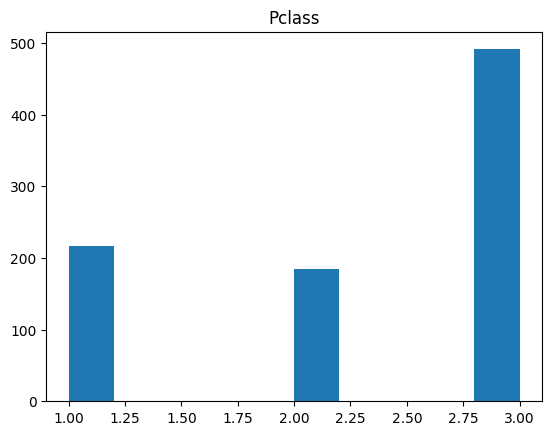

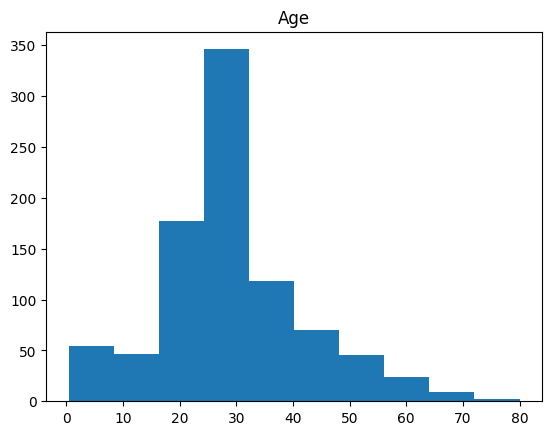

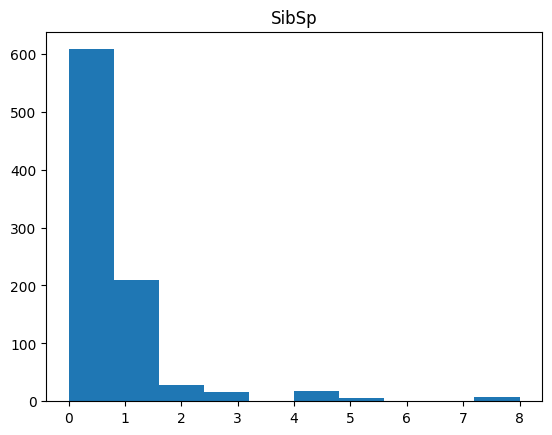

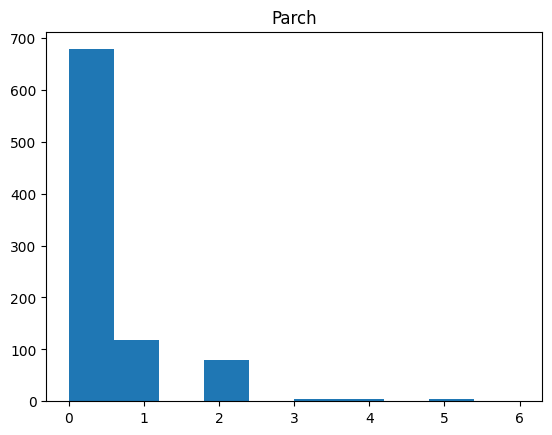

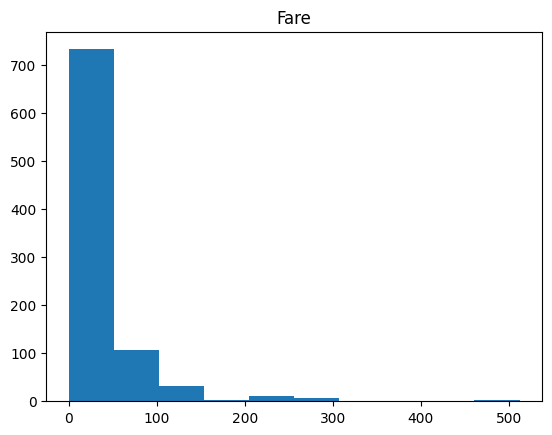

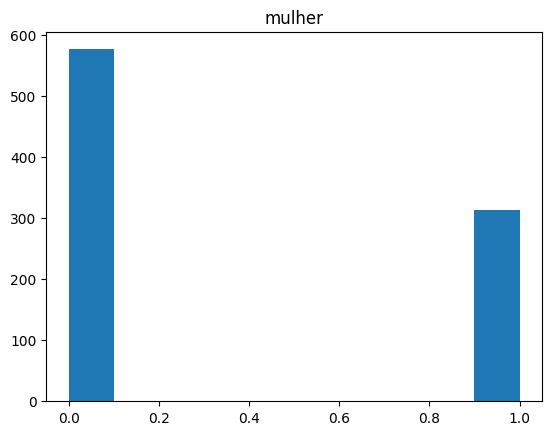

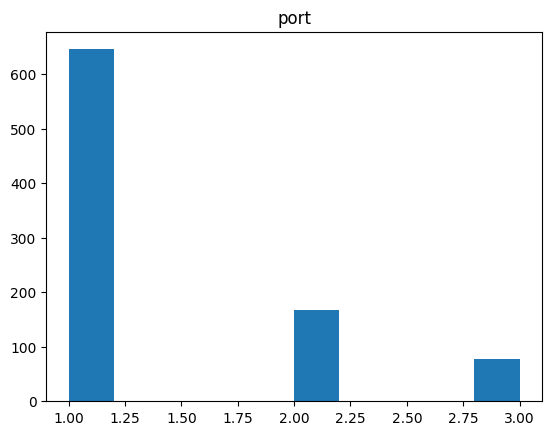

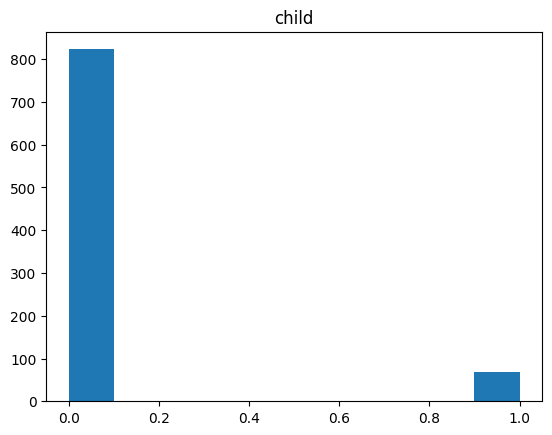

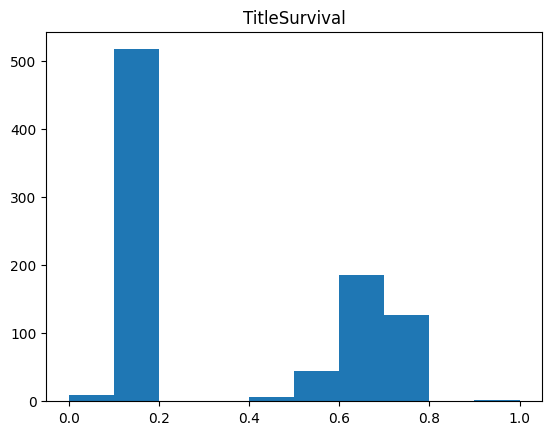

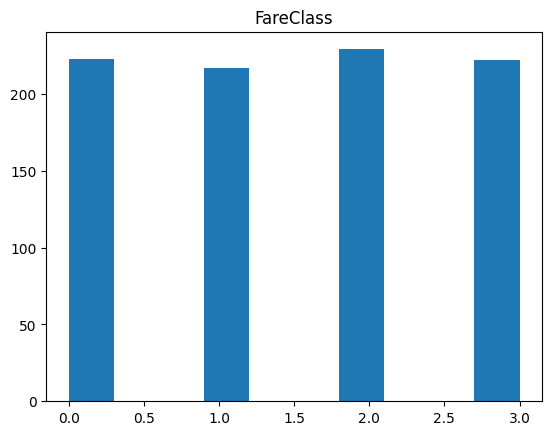

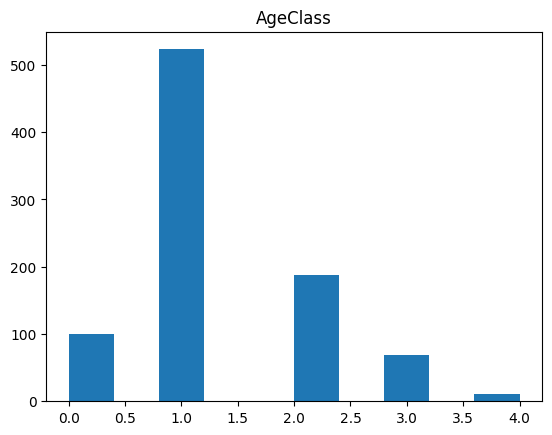

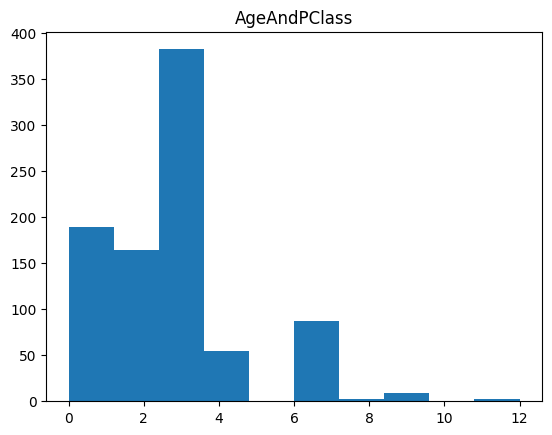

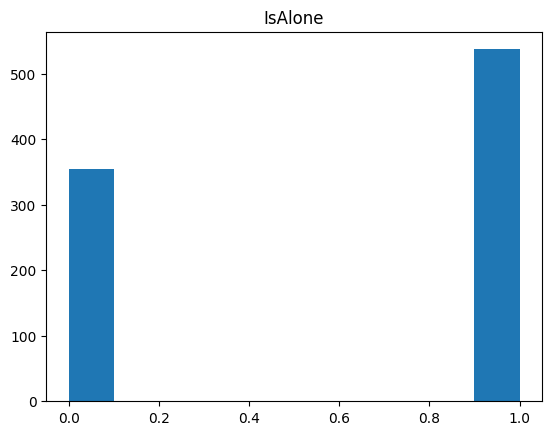

In [124]:
#%% Visualization

for i in X_train.columns:
    plt.hist(X_train[i])
    plt.title(i)
    plt.show()

<h2>Padronização das variáveis (Features)</h2>
O StandardScaler padroniza as features com média 0 e desvio padrão 1.
<p><strong>Referência:</strong></p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html" target="_blank">Visite a documentação StandardScaler</a>

In [125]:
#%% Standardization of Variables (Padrão das variáveis)
scaler = StandardScaler() #media 0 e desvio padrão 1

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

<h2>Matriz de Correlação</h2>

                 Pclass       Age     SibSp     Parch      Fare    mulher  \
Pclass         1.000000 -0.331339  0.083081  0.018443 -0.549500 -0.131900   
Age           -0.331339  1.000000 -0.232625 -0.179191  0.091566 -0.084153   
SibSp          0.083081 -0.232625  1.000000  0.414838  0.159651  0.114631   
Parch          0.018443 -0.179191  0.414838  1.000000  0.216225  0.245489   
Fare          -0.549500  0.091566  0.159651  0.216225  1.000000  0.182333   
mulher        -0.131900 -0.084153  0.114631  0.245489  0.182333  1.000000   
port           0.045702  0.007461 -0.059961 -0.078665  0.062142  0.116569   
child          0.111356 -0.553774  0.354531  0.372819 -0.002138  0.071106   
TitleSurvival -0.130150 -0.162915  0.224628  0.330709  0.188858  0.931759   
FareClass     -0.628459  0.073224  0.394248  0.393048  0.576836  0.248940   
AgeClass      -0.358769  0.931120 -0.218747 -0.135227  0.123640 -0.070220   
AgeAndPClass   0.318643  0.654514 -0.224716 -0.124138 -0.249819 -0.158907   

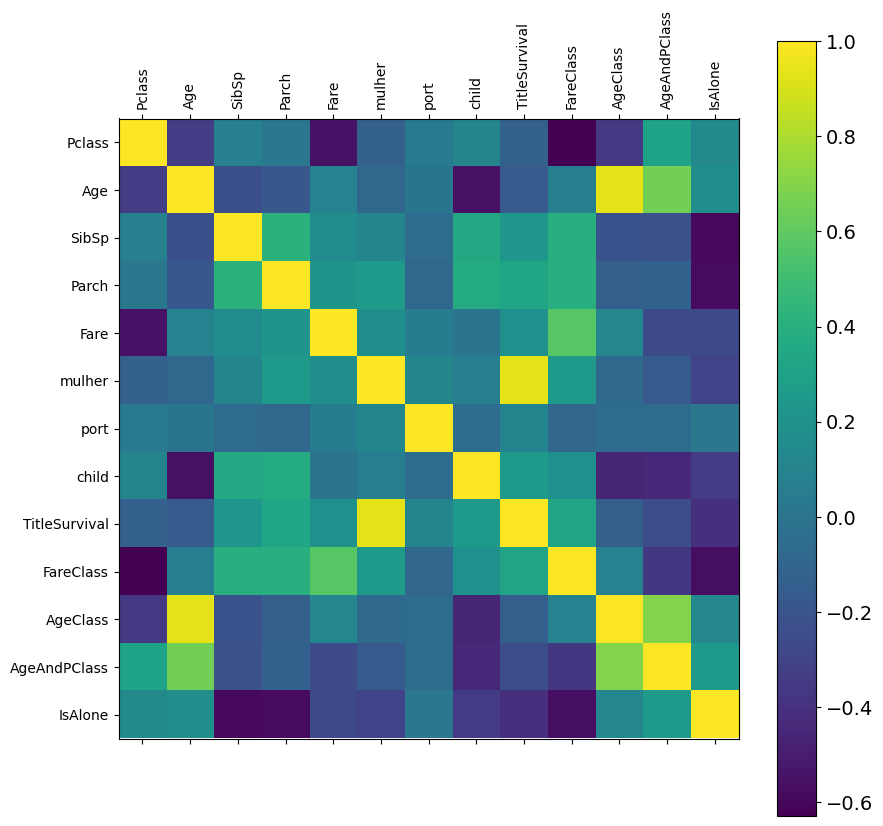

In [126]:
#%% Correlation Matrix

corrMatrix = X_train[features].corr()
#plt.matshow(corrMatrix)
plt.show()

print(corrMatrix)
f = plt.figure(figsize=(10, 10))
plt.matshow(corrMatrix, fignum=f.number)
plt.xticks(range(X_train[features].shape[1]), X_train[features].columns, fontsize=10, rotation=90)
plt.yticks(range(X_train[features].shape[1]), X_train[features].columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


<h2>Balanceamento de carga (SMOTE)</h2>
<p><strong>Referência:</strong></p>
<a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html" target="_blank">Visite a documentação SMOTE</a>

In [127]:
#%% Balanceamento de carga (SMOTE)
#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=0)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train_sc, y_train)

X_train_balanced = X_train_sc
y_train_balanced = y_train

<h2>Validação Cruzada Estratificada</h2>
<p><strong>Referência:</strong></p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html" target="_blank">Visite a documentação StratifiedKFold</a>

In [128]:
#%% Validação Cruzada Estratificada
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

<h2>Logistic Regression</h2>
<p><strong>Referência:</strong></p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html" target="_blank">Visite a documentação LogisticRegression</a>

In [129]:
#%% Logistic Regression
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression (random_state = 0)
score = cross_val_score(model_lr, X_train_balanced, y_train_balanced, cv = 10)
print(np.mean(score))

0.8181897627965045


<h2>xgboost - XGBClassifier</h2>
<p><strong>Referência:</strong></p>
<a href="https://xgboost.readthedocs.io/en/stable/get_started.html" target="_blank">Visite a documentação XGBClassifier</a>

In [130]:
#%%XGBClassifier
from xgboost import XGBClassifier

model_xgb = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=0)
score = cross_val_score(model_xgb, X_train_balanced, y_train_balanced, cv = 10)
print(np.mean(score))

0.838414481897628


<h2>Naive Bayes para Classificação</h2>
<p><strong>Referência:</strong></p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html" target="_blank">Visite a documentação GaussianNB</a>

In [131]:
#%% Naive Bayes para Classificação
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
score = cross_val_score(model_nb, X_train_balanced, y_train_balanced, cv = 10)
print(np.mean(score))

0.795792759051186


<h2>KNN para classificação</h2>
<p><strong>Referência:</strong></p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html" target="_blank">Visite a documentação KNeighborsClassifier</a>

In [132]:
#%% KNN para classificação
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors = 5, p = 2)
score = cross_val_score(model_knn, X_train_balanced, y_train_balanced, cv = 10)
print(np.mean(score))

0.8227215980024969


<h2>SVM para classificação</h2>
<p><strong>Referência:</strong></p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html" target="_blank">Visite a documentação SVC</a>

In [133]:
#%% SVM para classificação
from sklearn.svm import SVC

model_svc = SVC(C = 3, kernel = 'rbf', degree = 2, gamma = 0.1)
score = cross_val_score(model_svc, X_train_balanced, y_train_balanced, cv = 10)
print(np.mean(score))

0.8327715355805243


<h2>Decision Tree</h2>
<p><strong>Referência:</strong></p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html" target="_blank">Visite a documentação DecisionTreeClassifier</a>

In [134]:
#%% Decision Tree
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_split = 2, min_samples_leaf = 1, random_state = 0)
score = cross_val_score(model_dt,X_train_balanced, y_train_balanced, cv = cv)
print(np.mean(score))

0.8203870162297129


<h2> Otimização de hiperparametros - Decision Tree </h2>

In [135]:
#%% Otimização de hiperparametros - Decision Tree
def treinar_modelo(parametros):
  model_dt = DecisionTreeClassifier(criterion = parametros[0], max_depth = parametros[1], min_samples_split = parametros[2], min_samples_leaf = parametros[3], random_state = 0)
  score = cross_val_score(model_dt, X_train_balanced, y_train_balanced, cv = cv)
  mean_score = np.mean(score)
  print(np.mean(score))
  return -mean_score    

parametros = [('entropy', 'gini', 'log_loss'),
              (2, 10),
              (2, 6),
              (1, 3)]

otimos_dt = gp_minimize(treinar_modelo, parametros, random_state = 0, verbose = 1, n_calls = 30, n_random_starts = 10)
print(otimos_dt.fun, otimos_dt.x)

Iteration No: 1 started. Evaluating function at random point.
0.8214856429463172
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0410
Function value obtained: -0.8215
Current minimum: -0.8215
Iteration No: 2 started. Evaluating function at random point.
0.8260174781523096
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0319
Function value obtained: -0.8260
Current minimum: -0.8260
Iteration No: 3 started. Evaluating function at random point.
0.8237578027465668
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0349
Function value obtained: -0.8238
Current minimum: -0.8260
Iteration No: 4 started. Evaluating function at random point.
0.8047066167290886
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0367
Function value obtained: -0.8047
Current minimum: -0.8260
Iteration No: 5 started. Evaluating function at random point.
0.8158676654182273
Iteration No: 5 ended. Evaluation done at random point.
Time ta

<h2>Modelo final - Decision Tree com otimização de hiperparâmetros</h2>

In [136]:
#%% modelo final - Decision Tree
model_dt = DecisionTreeClassifier(criterion = otimos_dt.x[0], max_depth = otimos_dt.x[1], min_samples_split = otimos_dt.x[2], min_samples_leaf = otimos_dt.x[3], random_state = 0)

model_dt.fit(X_train_balanced, y_train_balanced)
y_pred = model_dt.predict(X_train_balanced)

mc = confusion_matrix(y_train_balanced, y_pred)
print(mc)
score = model_dt.score(X_train_balanced, y_train_balanced)
print(score)

[[495  54]
 [ 75 267]]
0.8552188552188552


<h2>Random Forest</h2>
<p><strong>Referência:</strong></p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html" target="_blank">Visite a documentação sklearn.ensemble.RandomForestClassifier</a>

In [137]:
#%% Random Forest
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, random_state = 0)
score = cross_val_score(model_rf, X_train_balanced, y_train_balanced, cv = 10)
print(np.mean(score))

0.8271660424469414


<h2> Otimização de hiperparametros - Random Forest </h2>

In [138]:
#%% Otimização de hiperparametros - Random Forest

def treinar_modelo(parametros):
  model_rf = RandomForestClassifier(criterion = parametros[0], n_estimators = parametros[1], max_depth = parametros[2],
                                    min_samples_split = parametros[3], min_samples_leaf = parametros[4], random_state = 0, n_jobs = -1)
  score = cross_val_score(model_rf, X_train_balanced, y_train_balanced, cv = 10)
  mean_score = np.mean(score)
  print(np.mean(score))
  return -mean_score    

parametros = [('entropy', 'gini'),
              (100, 1000),
              (3, 20),
              (2, 10),
              (1, 10)]

otimos_rf = gp_minimize(treinar_modelo, parametros, random_state = 0, verbose = 1, n_calls = 20, n_random_starts = 10 )
print(otimos_rf.fun, otimos_rf.x)

Iteration No: 1 started. Evaluating function at random point.
0.8294631710362047
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 21.6541
Function value obtained: -0.8295
Current minimum: -0.8295
Iteration No: 2 started. Evaluating function at random point.
0.8294132334581772
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.1590
Function value obtained: -0.8294
Current minimum: -0.8295
Iteration No: 3 started. Evaluating function at random point.
0.8339825218476904
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.3898
Function value obtained: -0.8340
Current minimum: -0.8340
Iteration No: 4 started. Evaluating function at random point.
0.8249563046192261
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.8386
Function value obtained: -0.8250
Current minimum: -0.8340
Iteration No: 5 started. Evaluating function at random point.
0.8283395755305868
Iteration No: 5 ended. Evaluation done at random point.
Time

<h2> Modelo final - Random Forest com otimização de hiperparametros</h2>

In [139]:
#%% modelo final - Random Forest
model_rf = RandomForestClassifier(criterion = otimos_rf.x[0], n_estimators = otimos_rf.x[1], max_depth = otimos_rf.x[2],
                                  min_samples_split = otimos_rf.x[3], min_samples_leaf = otimos_rf.x[4], random_state = 0, n_jobs = -1)

model_rf.fit(X_train_balanced, y_train_balanced)
y_pred = model_rf.predict(X_train_balanced)

mc = confusion_matrix(y_train_balanced, y_pred)
print(mc)

score = model_rf.score(X_train_balanced, y_train_balanced)
print(score)

[[519  30]
 [ 86 256]]
0.8698092031425365


<h2> Ensanble model (Voting) </h2>

In [140]:
#%% Ensanble model (Voting)
from sklearn.ensemble import VotingClassifier

model_voting = VotingClassifier(estimators = [('LR', model_lr), ('KNN', model_knn), 
                                             ('SVC', model_svc), ('RF', model_rf), 
                                              ('DT', model_dt), ('XGB', model_xgb)], voting = 'hard')
model_voting.fit(X_train_balanced, y_train_balanced)
score = cross_val_score(model_voting, X_train_balanced, y_train_balanced, cv = 10)
print(np.mean(score))

0.838414481897628


In [141]:
#%% Stacking
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', model_rf),
    ('dt', model_dt),
    ('xgb', model_xgb),
    ('svc', model_svc)
]
model_stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
model_stack.fit(X_train_balanced, y_train_balanced)
score = cross_val_score(model_stack, X_train_balanced, y_train_balanced, cv = 10)
print(np.mean(score))

0.837278401997503


<h2> Predição nos dados de teste </h2>

In [27]:
#%% predição nos dados de teste

#set ids as PassengerId and predict survival 
ids = test_work['PassengerId']
predictions = model_rf.predict(X_test_sc)

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({'PassengerId' : ids, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

